## Работа с данными

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile

# URL to the repository (modify this if the dataset is hosted in a specific location or file)
DATASET_URL = 'https://github.com/DeepTrackAI/MNIST_dataset/raw/main/mnist.zip'

response = requests.get(DATASET_URL)
with ZipFile(BytesIO(response.content)) as z:
    z.extractall()

# Now you can load the dataset using your preferred library, e.g., deeplay, PyTorch, TensorFlow.

In [ ]:
def move_dirs():
  for i in range(10):
    os.makedirs(f'/content/mnist_dataset/train/{i}')
    os.makedirs(f'/content/mnist_dataset/test/{i}')

  src = '/content/mnist'
  dst = '/content/mnist_dataset'
  for filename in os.listdir('/content/mnist/train'):
    os.rename(
        f'{src}/train/{filename}',
        f'{dst}/train/{filename[0]}/{filename}'
    )
  for filename in os.listdir('/content/mnist/test'):
    os.rename(
        f'{src}/test/{filename}',
        f'{dst}/test/{filename[0]}/{filename}'
    )

move_dirs()

In [ ]:
sm_train = 0
sm_test = 0

print("Train")
for i in range(10):
  print(f"{i}: {len(os.listdir(f'/content/mnist_dataset/train/{i}'))}")
  sm_train += len(os.listdir(f'/content/mnist_dataset/train/{i}'))
print()

print("Test")
for i in range(10):
  print(f"{i}: {len(os.listdir(f'/content/mnist_dataset/test/{i}'))}")
  sm_test += len(os.listdir(f'/content/mnist_dataset/test/{i}'))
print()

print(f'Train total: {sm_train}')
print(f'Test total: {sm_test}')

Train
0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949

Test
0: 980
1: 1135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009

Train total: 60000
Test total: 10000


In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_dataset = ImageFolder('/content/mnist_dataset/train', transform=transforms)
test_dataset = ImageFolder('/content/mnist_dataset/test', transform=transforms)

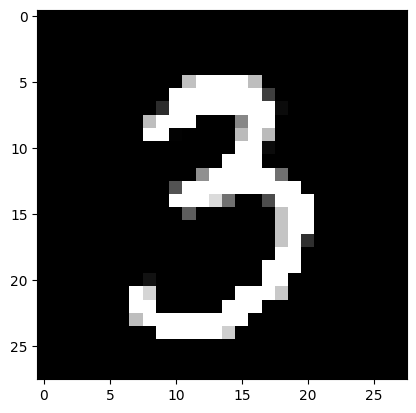

In [ ]:
plt.imshow(train_dataset[20000][0].permute(1, 2, 0));

In [ ]:
train_dataloader = DataLoader(train_dataset,  batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset,  batch_size=64, shuffle=False)

In [ ]:
for x_train, y_train in train_dataloader:
  print(x_train.shape)
  print(y_train.shape)
  break

torch.Size([64, 3, 28, 28])
torch.Size([64])


## Обучение сети

In [ ]:
def train(model, optimizer, train_loader, test_loader, epochs=10, validate=True):

  for epoch in range(epochs):
      print(f"Epoch {epoch}:")
      for x_train, y_train in tqdm(train_loader):
          x_train = x_train.to(device)
          y_train = y_train.to(device)

          y_pred = model(x_train)
          loss = F.cross_entropy(y_pred, y_train)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

      if validate and epoch % 2 != 0:
          with torch.no_grad():
              epoch_loss = []
              epoch_accuracy = []
              for x_test, y_test in test_loader:
                  x_test = x_test.to(device)
                  y_test = y_test.to(device)

                  y_pred = model(x_test)
                  loss = F.cross_entropy(y_pred, y_test).cpu()
                  accuracy = (y_pred.argmax(dim=1) == y_test).float().cpu().tolist()

                  epoch_loss.append(loss)
                  epoch_accuracy.extend(accuracy)

          print(f"Validation mean loss: {np.mean(epoch_loss)}")
          print(f"Validation mean accuracy: {np.mean(epoch_accuracy)}")
          print("========================================")

In [ ]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.MaxPool2d(2)
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(16 * 14 * 14, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)

        return x

In [ ]:
model = ConvNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, optimizer, train_dataloader, test_dataloader)

Epoch 0:


100%|██████████| 938/938 [00:26<00:00, 35.25it/s]


Epoch 1:


100%|██████████| 938/938 [00:26<00:00, 35.29it/s]


Validation mean loss: 0.2662326693534851
Validation mean accuracy: 0.9183
Epoch 2:


100%|██████████| 938/938 [00:26<00:00, 35.50it/s]


Epoch 3:


100%|██████████| 938/938 [00:26<00:00, 35.05it/s]


Validation mean loss: 0.25771909952163696
Validation mean accuracy: 0.9258
Epoch 4:


100%|██████████| 938/938 [00:26<00:00, 35.65it/s]


Epoch 5:


100%|██████████| 938/938 [00:26<00:00, 35.37it/s]


Validation mean loss: 0.15236470103263855
Validation mean accuracy: 0.9568
Epoch 6:


100%|██████████| 938/938 [00:26<00:00, 35.20it/s]


Epoch 7:


100%|██████████| 938/938 [00:26<00:00, 34.95it/s]


Validation mean loss: 0.14606472849845886
Validation mean accuracy: 0.955
Epoch 8:


100%|██████████| 938/938 [00:26<00:00, 35.05it/s]


Epoch 9:


100%|██████████| 938/938 [00:27<00:00, 34.49it/s]


Validation mean loss: 0.1576022058725357
Validation mean accuracy: 0.9607


## Играемся

In [ ]:
y_pred = torch.tensor([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
])

y_test = torch.tensor([
    0, 1, 2, 3
])

F.cross_entropy(y_pred, y_test)

(y_pred.argmax(dim=1) == y_test).float().tolist()

[1.0, 1.0, 1.0, 1.0]

In [ ]:
a = torch.Tensor([[
    [1, 2],
    [3, 4]
]])

conv = nn.Conv2d(1, 1, 1)
conv.weight

Parameter containing:
tensor([[[[-0.0177]]]], requires_grad=True)

In [ ]:
conv(a)

tensor([[[0.3300, 0.3122],
         [0.2945, 0.2768]]], grad_fn=<SqueezeBackward1>)

In [ ]:
# Входная матрица 3x3 (формат: [batch_size, channels, height, width])
input_tensor = torch.tensor([[[[1, 2, 3],
                               [4, 5, 6],
                               [7, 8, 9]]]], dtype=torch.float32)

# Ядро свёртки 2x2 (фильтр)
kernel = torch.tensor([[[[-1, 0],
                         [0, 1]]]], dtype=torch.float32)

# Создаём слой Conv2d вручную с заданными параметрами
conv_layer = nn.Conv2d(
    in_channels=1,      # 1 входной канал (т.к. чёрно-белое "изображение")
    out_channels=1,      # 1 выходной канал
    kernel_size=2,       # размер ядра 2x2
    stride=1,            # шаг 1
    padding=0,           # без дополнения нулями
    bias=False           # отключаем смещение (bias), чтобы оставить только свёртку
)

# Вручную задаём веса фильтра (наше ядро)
conv_layer.weight.data = kernel

# Применяем свёртку
output = conv_layer(input_tensor)

print("Входная матрица:\n", input_tensor.squeeze())
print("\nЯдро свёртки:\n", kernel.squeeze())
print("\nРезультат свёртки:\n", output.squeeze())

Входная матрица:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Ядро свёртки:
 tensor([[-1.,  0.],
        [ 0.,  1.]])

Результат свёртки:
 tensor([[4., 4.],
        [4., 4.]], grad_fn=<SqueezeBackward0>)


In [ ]:
import torch
import torch.nn as nn

input_tensor = torch.tensor([[[[1, 2, 3],
                              [4, 5, 6],
                              [7, 8, 9]]]], dtype=torch.float32)

conv_layer = nn.Conv2d(
    in_channels=1,
    out_channels=2,  # Теперь 2 выхода!
    kernel_size=2,
    stride=1,
    padding=0,
    bias=False
)

# Задаём два фильтра вручную
conv_layer.weight.data = torch.tensor([
    [[[-1, 0], [0, 1]]],  # K1
    [[[1, 0], [0, -1]]]   # K2
], dtype=torch.float32)

output = conv_layer(input_tensor)
print("Выход (2 канала):\n", output.squeeze())

Выход (2 канала):
 tensor([[[ 4.,  4.],
         [ 4.,  4.]],

        [[-4., -4.],
         [-4., -4.]]], grad_fn=<SqueezeBackward0>)
